<a href="https://colab.research.google.com/github/khenm/basic_image_retrieval/blob/feature%2Fimage_retrieval/simple_image_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Basic Image Retrieval
<p align="justify">
In this project, we will build a simple image retrieval system by using pre-trained Deep Learning model (CLIP) to encode the images and extract features. Then we will use these encoded features as queries for retrieving similar images through algorithms measuring the similarity.
</p>

In [ ]:
# download data
!gdown 1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF
!unzip data.zip

In [5]:
# load libraries
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
# get the image paths where 'data/train' is the root folder for data.
ROOT = 'data'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))

In [7]:
# read image
def read_image_from_path(path, size=(224, 224)):
    img = Image.open(path).convert('RGB').resize(size)
    return np.array(img)


def folder_to_images(folder, size):
    list_dir = [folder + '/' + name for name in os.listdir(folder)]
    images_np = np.zeros(shape=(len(list_dir), *size, 3))
    images_path = []
    for i, path in enumerate(list_dir):
        images_np[i] = read_image_from_path(path, size)
        images_path.append(path)
    images_path = np.array(images_path)
    return images_np, images_path

In [10]:
# plot the top 5 images
def plot_results(query_path, ls_path_score, reverse=False):
    # Sort the similar images by their rates (in order of 'reverse')
    ls_path_score = sorted(ls_path_score, key=lambda x: x[1], reverse=reverse)

    # Initialize figure
    fig, axs = plt.subplots(2, 3, figsize=(10, 5))
    plt.rcParams.update({'font.size': 10})

    # Display the query image
    query = read_image_from_path(query_path)
    query_name = os.path.basename(os.path.dirname(query_path)).split('.')[0]
    axs[0][0].imshow(query)
    axs[0][0].set_title(f'Query Image: {query_name}')
    axs[0][0].axis('off')

    # Display similar images and their rates
    for k, (path, _) in enumerate(ls_path_score[:5]):
        i = k + 1
        similar_img = read_image_from_path(path)
        image_name = os.path.basename(os.path.dirname(path)).split('.')[0]
        axs[i // 3][i % 3].imshow(similar_img)
        axs[i // 3][i % 3].set_title(f'Top {i}: {image_name}')
        axs[i // 3][i % 3].axis('off')

    plt.show()

#### Simple Image Retrieval with L1
The first correlation measure method is L1 distance between the images. L1 distance is the sum of the absolute differences between the images, which is:
$$
L_{1}(I_{1}, I_{2}) = \sum_{i} |I_{1}^{i} - I_{2}^{i}|
$$

In [8]:
# image retrieval with L1
def absolute_difference(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    return np.sum(np.abs(data - query), axis=axis_batch_size)


def get_l1_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            rates = absolute_difference(query, images_np)
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

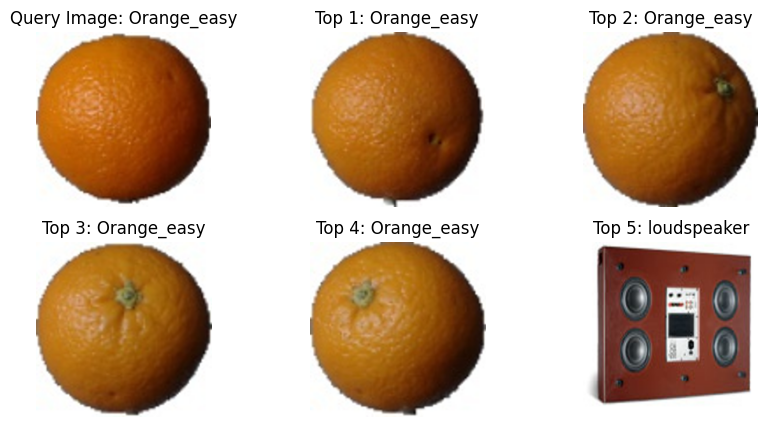

In [11]:
# sample 1
root_img_path = f'{ROOT}/train/'
query_path = f'{ROOT}/test/Orange_easy/0_100.jpg'
size = (448, 448)
query, ls_path_score = get_l1_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score)

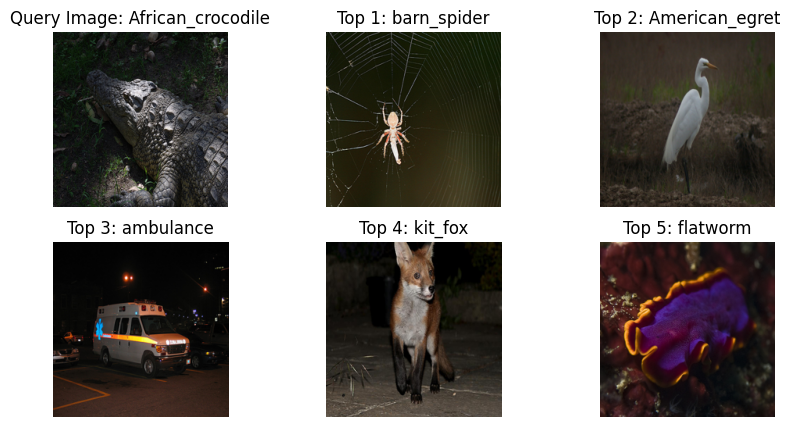

In [12]:
# sample 2
root_img_path = f'{ROOT}/train/'
query_path = f'{ROOT}/test/African_crocodile/n01697457_18534.JPEG'
size = (448, 448)
query, ls_path_score = get_l1_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score)

#### Image Retrieval with L2
L2 distance is the Euclidean distance between two points in space. The equation is:
$$
L2(I_1, I_2)=\sqrt{\sum_{i=0}^{n}(I_{1i}-I_{2i})^{2}}
$$

In [13]:
def mean_square_difference(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    return np.mean((data - query) ** 2, axis=axis_batch_size)

def get_l2_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            rates = mean_square_difference(query, images_np)
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

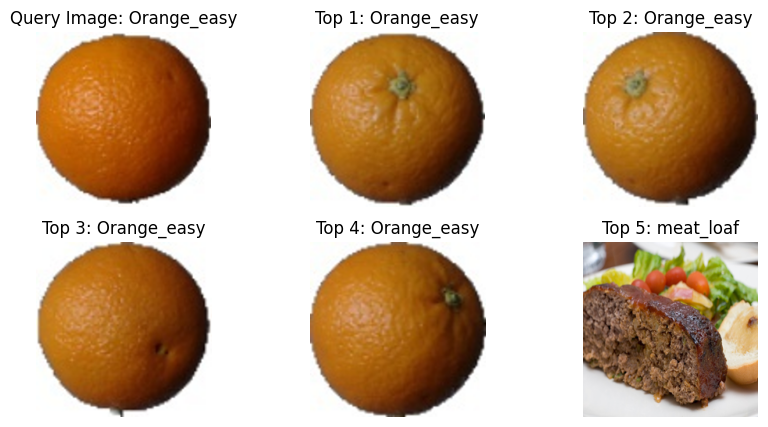

In [14]:
# sample 1
root_img_path = f'{ROOT}/train/'
query_path = f'{ROOT}/test/Orange_easy/0_100.jpg'
size = (448, 448)
query, ls_path_score = get_l2_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score)

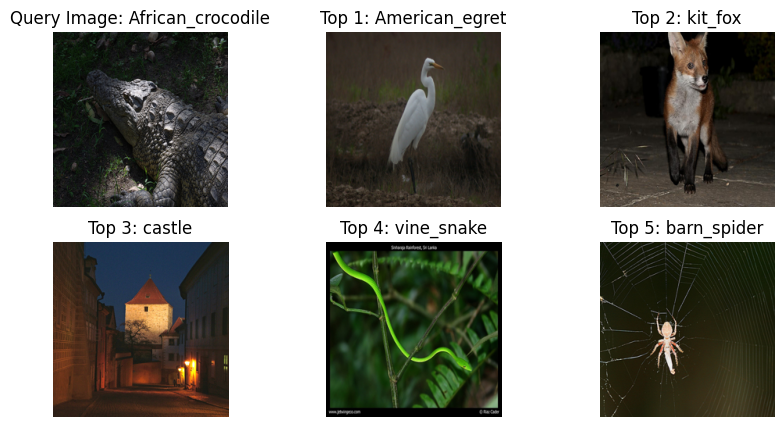

In [15]:
# sample 2
root_img_path = f'{ROOT}/train/'
query_path = f'{ROOT}/test/African_crocodile/n01697457_18534.JPEG'
size = (448, 448)
query, ls_path_score = get_l2_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score)

#### Image Retrieval with Cosine Similarity
Cosine Similarity is:
$$
cos(a, b) = \frac{a \cdot b}{||a|| \cdot ||b||} = \frac{\sum_{i = 1}^n a_ib_i}{\sqrt{\sum_{i = 1}^n a^2_i} \cdot \sqrt{\sum_{i = 1}^n b^2_i}}
$$

In [16]:
def cosine_similarity(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    query_norm = np.sqrt(np.sum(query ** 2))
    data_norm = np.sqrt(np.sum(data ** 2, axis = axis_batch_size))
    return np.sum(data * query, axis=axis_batch_size) / (query_norm * data_norm + np.finfo(float).eps)

In [18]:
def get_cosine_similarity_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            rates = cosine_similarity(query, images_np)
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

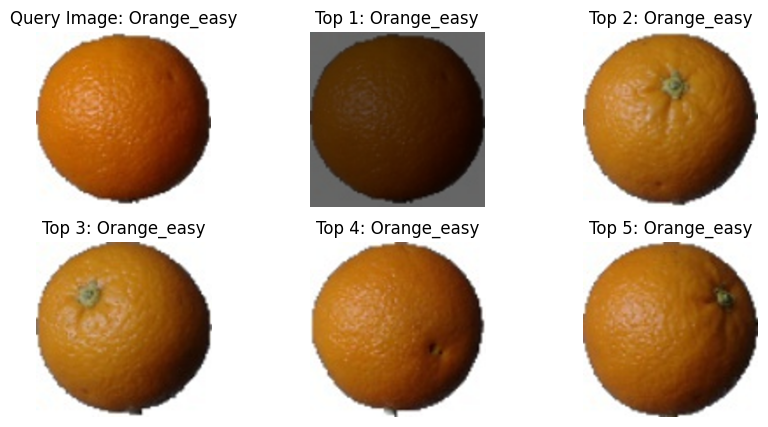

In [19]:
# Sample 1
root_img_path = f'{ROOT}/train/'
query_path = f'{ROOT}/test/Orange_easy/0_100.jpg'
size = (448, 448)
query, ls_path_score = get_cosine_similarity_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)   # reverse=True because the higher the values,
                                                        # the more similar they are.

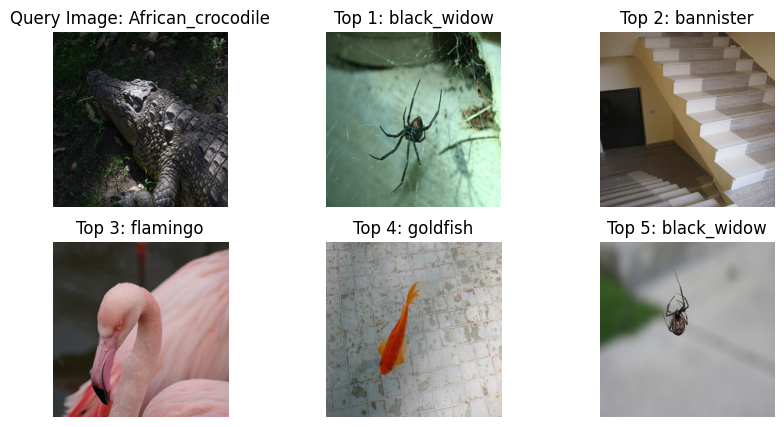

In [20]:
# Sample 2
root_img_path = f'{ROOT}/train/'
query_path  = f'{ROOT}/test/African_crocodile/n01697457_18534.JPEG'
size = (448, 448)
query, ls_path_score = get_cosine_similarity_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

#### Image Retrieval with Correlation Coefficient
We are using Pearsons' r to find the most similar images. The equation is:
$$
r = \frac{\sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y})}{\sqrt{\sum_{i=1}^{n}(x_{i}-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_{i}-\bar{y})^2}}
$$

In [21]:
def correlation_coefficient(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    query_mean = query - np.mean(query)
    data_mean = data - np.mean(data, axis=axis_batch_size, keepdims=True)
    query_norm = np.sqrt(np.sum(query_mean**2))
    data_norm = np.sqrt(np.sum(data_mean**2, axis=axis_batch_size))
    return np.sum(data_mean * query_mean, axis=axis_batch_size)/ (query_norm * data_norm + np.finfo(float).eps)

In [22]:
def get_correlation_coefficient_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            rates = correlation_coefficient(query, images_np)
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

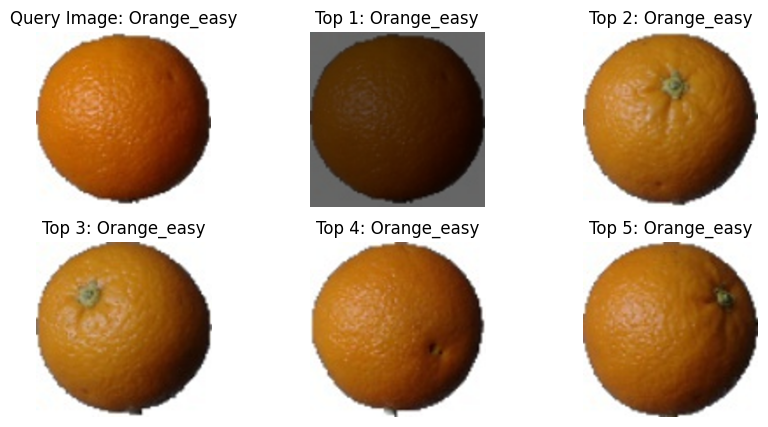

In [23]:
# Sample 1
root_img_path = f'{ROOT}/train/'
query_path = f'{ROOT}/test/Orange_easy/0_100.jpg'
size = (448, 448)
query, ls_path_score = get_correlation_coefficient_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

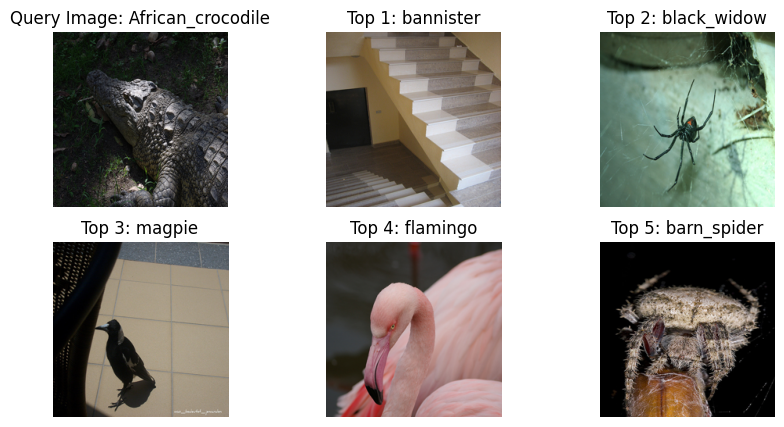

In [24]:
# Sample 2
root_img_path = f'{ROOT}/train/'
query_path  = f'{ROOT}/test/African_crocodile/n01697457_18534.JPEG'
size = (448, 448)
query, ls_path_score = get_correlation_coefficient_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

### Advanced Image Retrieval
<p align="justify">
To improve the performance of image retrieval, by using Deep Learning Model to extract feature vectors from images, we can get a more precises image. Image Retrieval with Deep Learning Model is a procfess where the model is trained to search and get images from a large dataset. The model has learned from large dataset multiple important features that are common in most of the images. Therefore, the model is able to analyze, recognize complicated aspects like color, texture, shape etc., which is not possible by using traditional image retrieval techniques.
</p>

#### 1. Prerequisites
<p align="justify">
In this project, we use two important libraries: chromadb and open-clip-torch. Chromadb is a python library that supports the management of large datasets and access to images. Open-clip-torch is a pytorch implementation of OpenAI's CLIP model. We will use the CLIP model as it is a powerful tool to analyze image features through deep learning.
</p>

In [ ]:
!pip install chromadb
!pip install open_clip_torch

In [27]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

<p align="justify">
CLIP Model will be used in sequence as previous steps, but fuse with an improvement of a vector extraction function. The following code section aims to create a new embedding function to get input of an image and using _encode_image method from OpenClipEmbeddingFunction to extract into feature vector.
</p>

In [28]:
embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image)
    return np.array(embedding)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

#### 2. Embedding vector retrieval with metric measurements

In [31]:
#@title L1 distance
def get_l1_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            embedding_list = []
            for idx_img in range(images_np.shape[0]):
               embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
               embedding_list.append(embedding)
            rates = absolute_difference(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

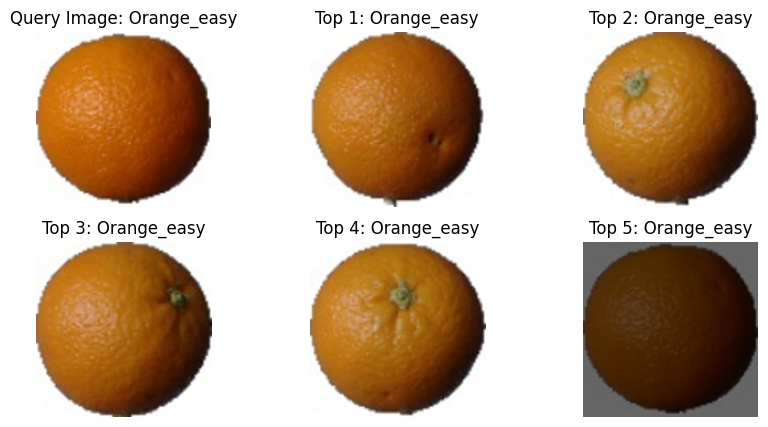

In [30]:
# sample 1
root_img_path = f'{ROOT}/train/'
query_path = f'{ROOT}/test/Orange_easy/0_100.jpg'
size = (448, 448)
query, ls_path_score = get_l1_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score)

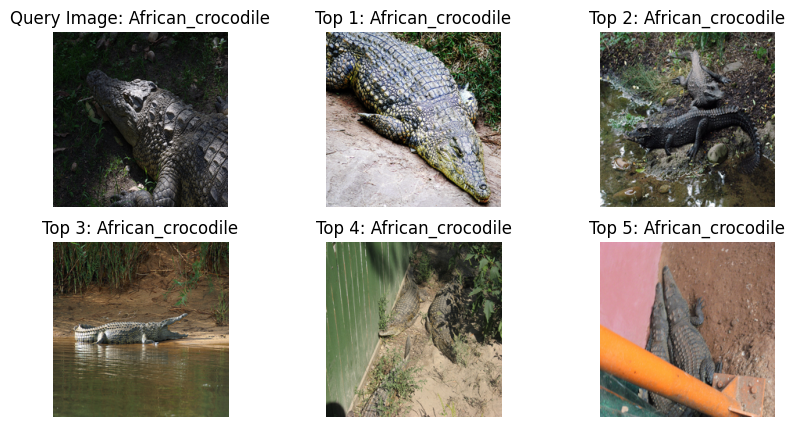

In [34]:
# Sample 2
root_img_path = f'{ROOT}/train/'
query_path  = f'{ROOT}/test/African_crocodile/n01697457_18534.JPEG'
size = (448, 448)
query, ls_path_score = get_l1_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score)

In [40]:
#@title L2 distance
def get_l2_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            rates = mean_square_difference(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

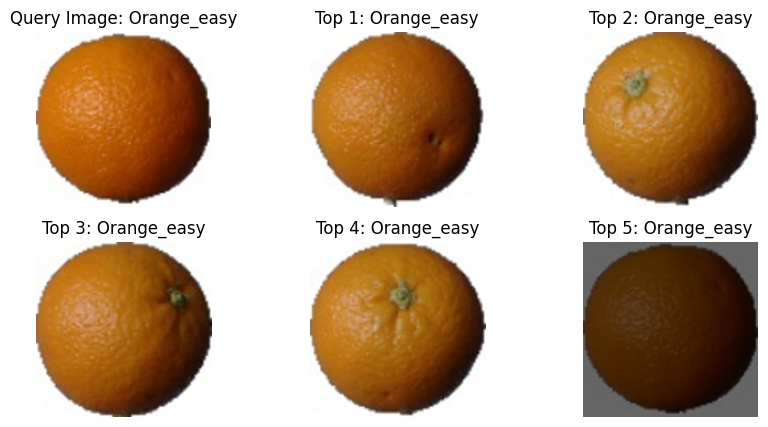

In [41]:
# sample 1
root_img_path = f'{ROOT}/train/'
query_path = f'{ROOT}/test/Orange_easy/0_100.jpg'
size = (448, 448)
query, ls_path_score = get_l2_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score)

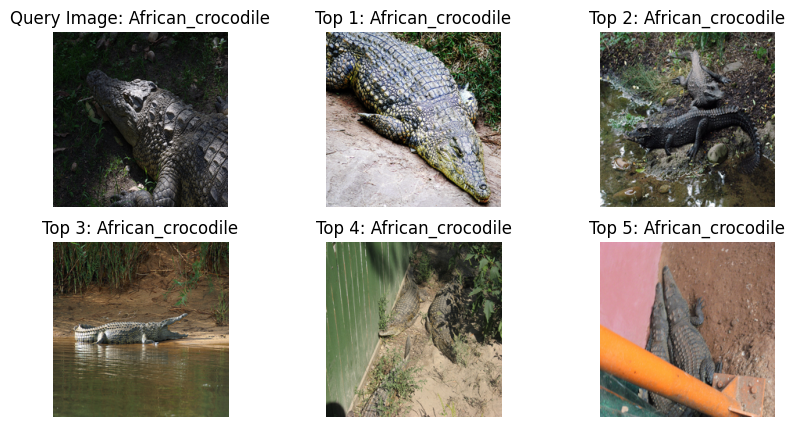

In [35]:
# Sample 2
root_img_path = f'{ROOT}/train/'
query_path  = f'{ROOT}/test/African_crocodile/n01697457_18534.JPEG'
size = (448, 448)
query, ls_path_score = get_l2_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score)

In [36]:
#@title Cosine Similarity
def get_cosine_similarity_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            rates = cosine_similarity(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

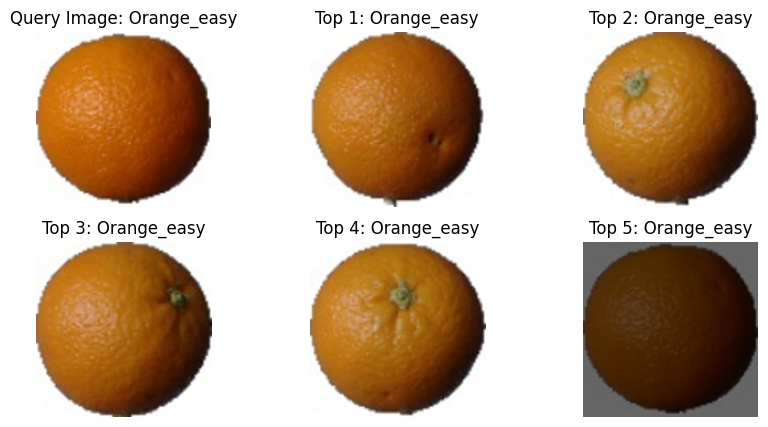

In [37]:
# sample 1
root_img_path = f'{ROOT}/train/'
query_path = f'{ROOT}/test/Orange_easy/0_100.jpg'
size = (448, 448)
query, ls_path_score = get_cosine_similarity_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

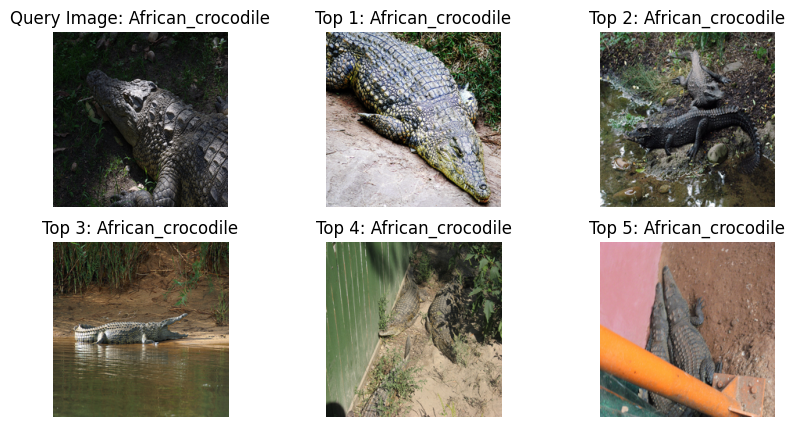

In [38]:
# Sample 2
root_img_path = f'{ROOT}/train/'
query_path  = f'{ROOT}/test/African_crocodile/n01697457_18534.JPEG'
size = (448, 448)
query, ls_path_score = get_cosine_similarity_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

### Optimal Solution
<p align="justify">
The previous samples are not optimized as every retrieval needs to rerun the whole CLIP model, which is time consuming. Therefore, we need adjustment: first, we extract feature vectors from images from images' paths and store them into database.
</p>

In [39]:
def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = path + '/' + label
        filenames = os.listdir(label_path)
        for filename in filenames:
            filepath = label_path + '/' + filename
            files_path.append(filepath)
    return files_path

data_path = f'{ROOT}/train/'
files_path = get_files_path(path=data_path)

#### Image Retrieval with L2 Collection
<p align="justify">
In ChromaDB, 'collection' is an important concept, used in data management. A collection in ChromadDB can be intepreted as a set of indexed vectors or files that are stored and categorzized by features (Same as 'table' in some data structures or 'collection' in MongoDB).

The following section will define 'add_embedding' to help extract, store and retrieve feature vectors.
</p>

In [42]:
from tqdm import tqdm
import io
def add_embedding(collection, files_path):
    ids = []
    embeddings = []
    for id_filepath, filepath in tqdm(enumerate(files_path)):
        ids.append(f'id_{id_filepath}')
        image = Image.open(filepath)
        img_array = np.array(image)
        embedding = get_single_image_embedding(image=img_array)
        embedding = embedding.tolist()
        embeddings.append(embedding)
    collection.add(
        embeddings=embeddings,
        ids=ids
    )

Next, we initialize a Chroma Client and create a new collection using L2 function to compare embedding vectors. Then, we call add_embedding to add feature vectors into this collection.

In [45]:
# Create a Chroma Client
import chromadb
chroma_client = chromadb.Client()
# Create a collection
l2_collection = chroma_client.get_or_create_collection(
    name='l2_collection',
    metadata = {"hnsw:space" : "l2"}
)
add_embedding(collection=l2_collection, files_path=files_path)

595it [02:43,  3.65it/s]


In [46]:
def search(image_path, collection, n_results):
    query_image = Image.open(image_path)
    query_image = np.asarray(query_image)
    query_embedding = get_single_image_embedding(query_image)
    query_embedding = query_embedding.tolist()
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results
    )
    return results

In [47]:
# modify plot_results function
def plot_results(image_path, files_path, results):
    # Initialize figure
    fig, axs = plt.subplots(2, 3, figsize=(10, 5))
    plt.rcParams.update({'font.size': 10})

    # Display the query image
    query = read_image_from_path(image_path)
    query_name = os.path.basename(os.path.dirname(query_path)).split('.')[0]
    axs[0][0].imshow(query)
    axs[0][0].set_title(f'Query Image: {query_name}')
    axs[0][0].axis('off')

    # Display similar images and their rates
    for k, result_index in enumerate(results['ids'][0]):
        i = k + 1
        index = int(result_index[-2:])
        result_path = files_path[index]
        similar_img = read_image_from_path(result_path)
        image_name = os.path.basename(os.path.dirname(result_path)).split('.')[0]
        axs[i // 3][i % 3].imshow(similar_img)
        axs[i // 3][i % 3].set_title(f'Top {i}: {image_name}')
        axs[i // 3][i % 3].axis('off')

    plt.show()

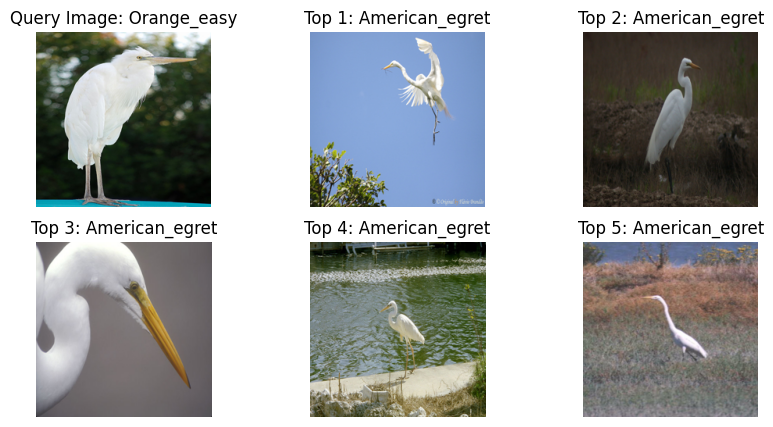

In [48]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
l2_results = search(image_path=test_path, collection=l2_collection, n_results=5)
plot_results(image_path=test_path, files_path=files_path, results=l2_results)

#### Image Retrieval with Cosine Similarity Collection

In [49]:
cosine_collection = chroma_client.get_or_create_collection(
    name='Cosine_collection',
    metadata = {"hnsw:space": 'cosine'}
)
add_embedding(collection=cosine_collection, files_path=files_path)

595it [02:50,  3.49it/s]


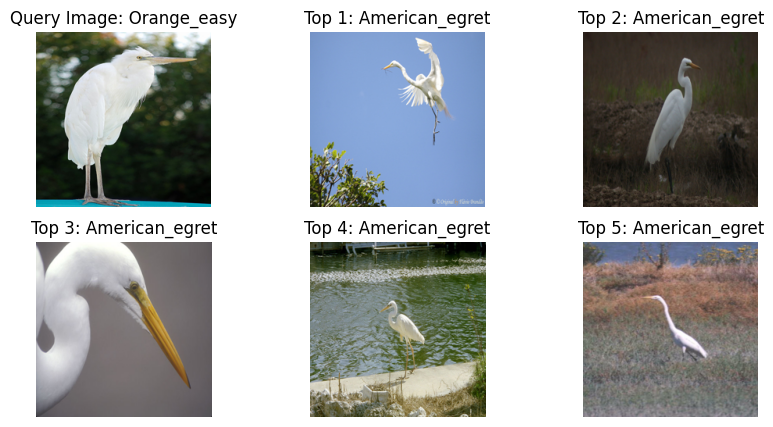

In [50]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
cosine_results = search(image_path=test_path, collection=cosine_collection, n_results=5)
plot_results(image_path=test_path, files_path=files_path, results=cosine_results)